In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import missingno as msno
import seaborn as sns
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [35]:
df = pd.read_csv('DataExtract_v3.csv') #read in CSV file provided

# MODEL

#### Create Y value

In [36]:
#Convert to datetime
df['AssignedDate']= pd.to_datetime(df['AssignedDate'])
df['FirstDeliverableProvidedDate']= pd.to_datetime(df['FirstDeliverableProvidedDate'])

In [37]:
#Count business days between dates
A = [d.date() for d in df['AssignedDate']]
B = [d.date() for d in df['FirstDeliverableProvidedDate']]

df['days_for_deal'] = np.busday_count(A, B)

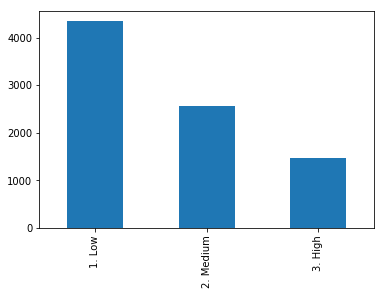

In [38]:
df['deal_complexity'] = np.where(df['days_for_deal'] <= 1, '1. Low',
                                 np.where(df['days_for_deal'] <= 7, '2. Medium', '3. High'
                                        ))
df['deal_complexity'].value_counts().plot(kind='bar')

In [39]:
df = df.drop(columns=['MyDealId', 'AssignedDate','IntakeDate', 'FirstDeliverableProvidedDate', 'days_for_deal',
                     'RegionValue', 'OwnerID'])

#### One Hot Encode and Create Factors

In [40]:
# df['OwnerID'] = df['OwnerID'].astype(object)
df['TechnologySolutionOwnerBadge'] = df['TechnologySolutionOwnerBadge'].astype(object)
df['SMEID'] = df['SMEID'].astype(object)
df['CustomerNumber'] = df['CustomerNumber'].astype(object)

In [41]:
df.columns

Index(['BookingSystemName', 'Assets', 'IsPrimary', 'OpportunityTypeValue',
       'CustomerNumber', 'dealstatusvalue', 'CountryValue',
       'TechnologySolutionOwnerBadge', 'SMEID', 'LOBNAME', 'Technologyname',
       'Fiscal Year', 'Fiscal Quarter', 'Fiscal Week', 'ContractRevenue',
       'LineItemRevenue', 'deal_complexity'],
      dtype='object')

In [42]:
cat_vars = ['BookingSystemName', 'OpportunityTypeValue', 'CustomerNumber', 'CountryValue', 'TechnologySolutionOwnerBadge', 'SMEID', 'LOBNAME', 'Technologyname', 'Fiscal Year', 'Fiscal Quarter', 'Fiscal Week', 'dealstatusvalue']

In [43]:
df = pd.get_dummies(data=df, columns=cat_vars)
print(df.shape)

(8392, 456)


In [44]:
df.head()

,Assets,IsPrimary,ContractRevenue,LineItemRevenue,deal_complexity,"BookingSystemName_DELL (DSA, Gii)","BookingSystemName_Dell (DSA,Gii)",BookingSystemName_EMC (MyQuotes),BookingSystemName_VCE (XACT),OpportunityTypeValue_CSG Acq – Relationship,...,Fiscal Week_202044,Fiscal Week_202045,Fiscal Week_202046,Fiscal Week_202047,Fiscal Week_202048,Fiscal Week_202049,Fiscal Week_202050,Fiscal Week_202051,dealstatusvalue_Deliverable Provided,dealstatusvalue_Won
0,503.862396,1,1295.00,1295.00,2. Medium,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,503.862396,0,263060.26,7964.80,2. Medium,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,503.862396,1,263060.26,255095.46,2. Medium,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0.000000,1,594.00,594.00,1. Low,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,9.000000,1,9849.46,9849.46,1. Low,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


#### Run Model

In [50]:
#Split data into train and test sets
X = df.drop(['deal_complexity'],axis=1)
Y = df['deal_complexity']

X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.20, random_state=1)

In [51]:
model = RandomForestClassifier(random_state=1, n_estimators = 10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy with model: ", model.score(X_test, y_test))

Accuracy with model:  0.680762358546754


In [52]:
#Perform some tuning on RF model
max_depth = [4, 8, 32, 64] #depth of each tree in forest
n_estimators = [200, 500] #number of trees in the forest

param_grid = dict(max_depth = max_depth, n_estimators = n_estimators)
model = RandomForestClassifier(random_state=1)
grid = GridSearchCV(estimator = model, param_grid = param_grid, cv = 5, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)
print("Accuracy of model with some tuning: ", grid.score(X_test, y_test), grid_result.best_params_)

Accuracy of model with some tuning:  0.7153067301965456 {'max_depth': 32, 'n_estimators': 500}


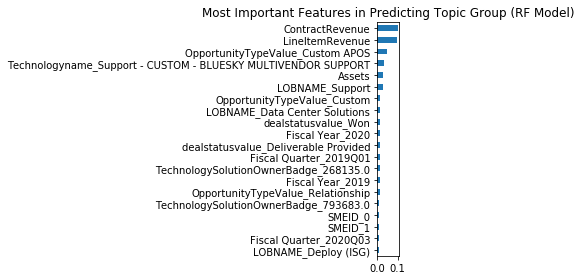

In [53]:
#See feature importance of best model
model = RandomForestClassifier(max_depth = 32, n_estimators = 500, random_state=1)
model.fit(X_train, y_train)

feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).sort_values().plot(kind='barh')

plt.title('Most Important Features in Predicting Topic Group (RF Model)')
plt.tight_layout()
plt.show()

In [17]:
# from numpy import loadtxt
# from xgboost import XGBClassifier

# model = XGBClassifier()
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
# print("Accuracy with model: ", model.score(X_test, y_test))

Accuracy with model:  0.6825491363907088


In [54]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[714, 107,  40],
       [110, 316,  88],
       [ 46, 145, 113]], dtype=int64)